# OV2295 Zenodo Data

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import scgenome

sample_ids = [
    'SA1090',
    'SA921',
    'SA922',
]



Download zenodo data using wget:

```
mkdir zenodo_data/
wget https://zenodo.org/record/5725635/files/ov2295_cell_cn.csv.gz?download=1 -O zenodo_data/ov2295_cell_cn.csv.gz
wget https://zenodo.org/record/5725635/files/ov2295_cell_metrics.csv.gz?download=1 -O zenodo_data/ov2295_cell_metrics.csv.gz
```

Alternatively - download directly from `https://zenodo.org/records/5725635`



# Load CN data


In [5]:

cn_data = pd.read_csv(
    'zenodo_data/ov2295_cell_cn.csv.gz',
    dtype={
        'cell_id': 'category',
        'sample_id': 'category',
        'library_id': 'category',
        'chr': 'category',
    })

metrics_data = pd.read_csv(
    'zenodo_data/ov2295_cell_metrics.csv.gz',
    dtype={
        'cell_id': 'category',
        'sample_id': 'category',
        'library_id': 'category',
    })

scgenome.utils.union_categories([cn_data, metrics_data])

hmmcopy = scgenome.pp.convert_dlp_hmmcopy(metrics_data, cn_data)


/Users/80024651/Documents/Boston/Ovarian_WGD_paper/scgenome/scgenome_env/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(



# Basic quality filtering


In [6]:
hmmcopy.obs.columns

Index(['unpaired_mapped_reads', 'paired_mapped_reads',
       'unpaired_duplicate_reads', 'paired_duplicate_reads', 'unmapped_reads',
       'percent_duplicate_reads', 'estimated_library_size', 'total_reads',
       'total_mapped_reads', 'total_duplicate_reads', 'total_properly_paired',
       'coverage_breadth', 'coverage_depth', 'median_insert_size',
       'mean_insert_size', 'standard_deviation_insert_size', 'index_sequence',
       'column', 'img_col', 'index_i5', 'sample_type', 'primer_i7',
       'experimental_condition', 'index_i7', 'cell_call', 'sample_id',
       'primer_i5', 'row', 'library_id', 'index', 'multiplier',
       'MSRSI_non_integerness', 'MBRSI_dispersion_non_integerness',
       'MBRSM_dispersion', 'autocorrelation_hmmcopy', 'cv_hmmcopy',
       'empty_bins_hmmcopy', 'mad_hmmcopy', 'mean_hmmcopy_reads_per_bin',
       'median_hmmcopy_reads_per_bin', 'std_hmmcopy_reads_per_bin',
       'total_mapped_reads_hmmcopy', 'total_halfiness', 'scaled_halfiness',
       'm

In [7]:

hmmcopy = hmmcopy[
    (hmmcopy.obs['total_reads'] > 500000) &
    (hmmcopy.obs['quality'] > 0.75)]


# Plot a cell

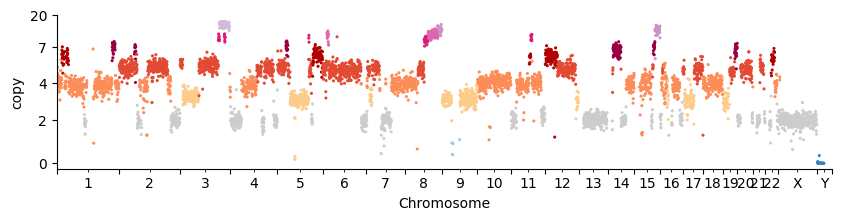

In [17]:

cell_id = hmmcopy.obs.index[0]

plt.figure(figsize=(10, 2))
scgenome.pl.plot_cn_profile(
    hmmcopy, cell_id,
    value_layer_name='copy',
    state_layer_name='state',
    squashy=True)
plt.legend().remove()



# Calculate clones using kmeans


In [9]:

hmmcopy = scgenome.tl.cluster_cells(hmmcopy, max_k=30)


/Users/80024651/Documents/Boston/Ovarian_WGD_paper/scgenome/scgenome_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/80024651/Documents/Boston/Ovarian_WGD_paper/scgenome/scgenome_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/80024651/Documents/Boston/Ovarian_WGD_paper/scgenome/scgenome_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/

/Users/80024651/Documents/Boston/Ovarian_WGD_paper/scgenome/scgenome_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='cluster_id', ylabel='cluster_size'>

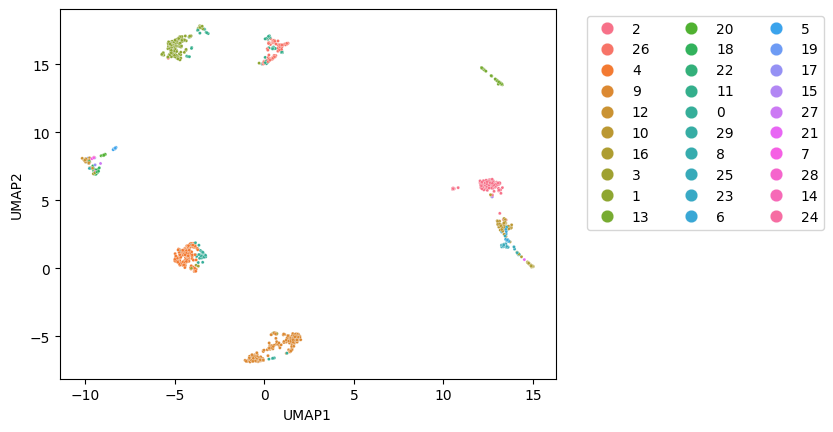

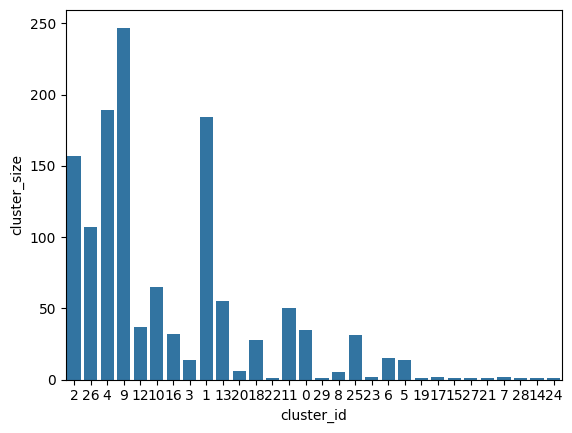

In [19]:

scgenome.tl.compute_umap(hmmcopy)

plt.figure()
sns.scatterplot(data=hmmcopy.obs, x='UMAP1', y='UMAP2', hue='cluster_id', s=5)
plt.legend(ncols=3, bbox_to_anchor=(1.05, 1.0), loc='upper left', markerscale=4.0)

plt.figure()
sns.barplot(data=hmmcopy.obs, x='cluster_id', y='cluster_size')



# Plot heatmap

Order by cluster, then by a secondary ordering from hierarchical clustering.


/Users/80024651/Documents/Boston/Ovarian_WGD_paper/scgenome/scgenome_env/lib/python3.9/site-packages/scgenome/tools/sorting.py:69: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


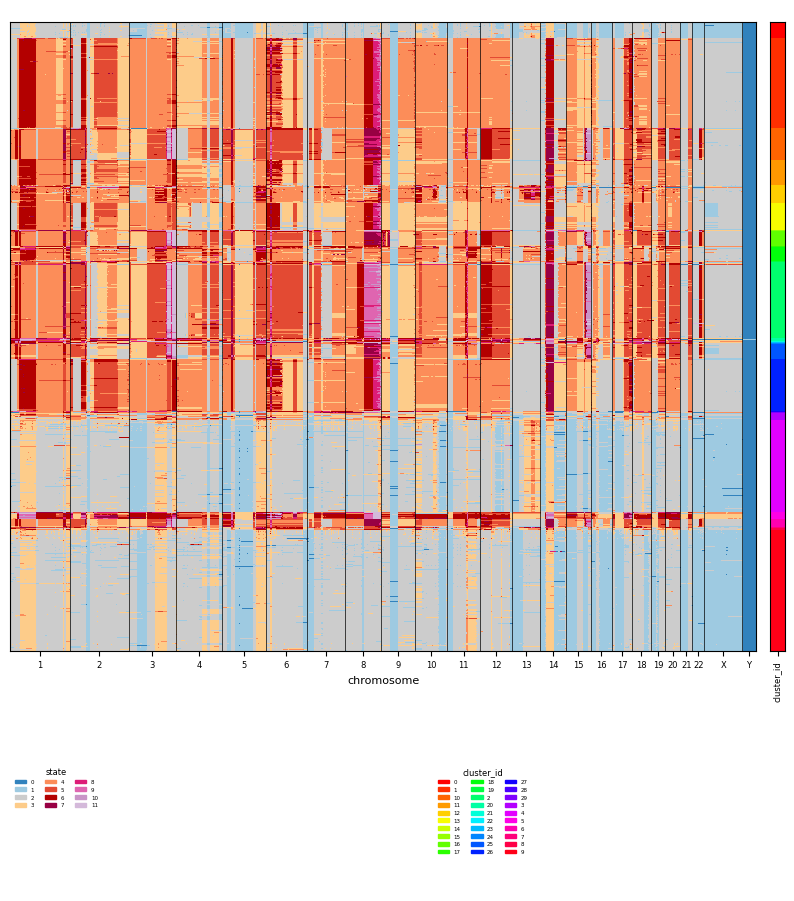

In [11]:

hmmcopy = scgenome.tl.sort_cells(hmmcopy, layer_name='copy')

fig = plt.figure(figsize=(10, 10))
g = scgenome.pl.plot_cell_cn_matrix_fig(
    hmmcopy,
    layer_name='state',
    cell_order_fields=['cluster_id', 'cell_order'],
    annotation_fields=['cluster_id'],
    fig=fig,
)



# Plot PCA components


<Axes: xlabel='Chromosome', ylabel='_X'>

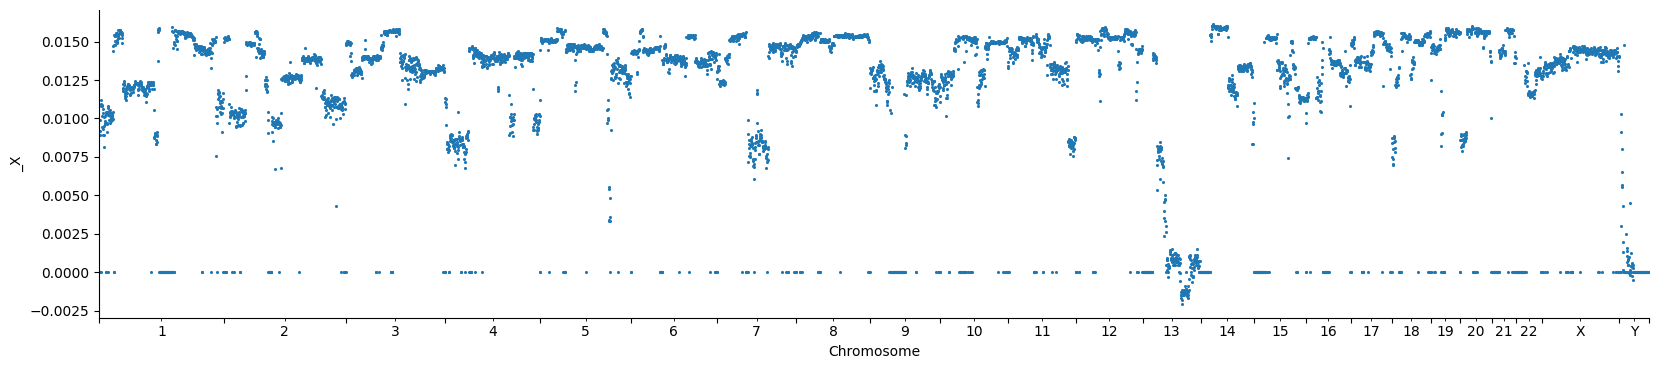

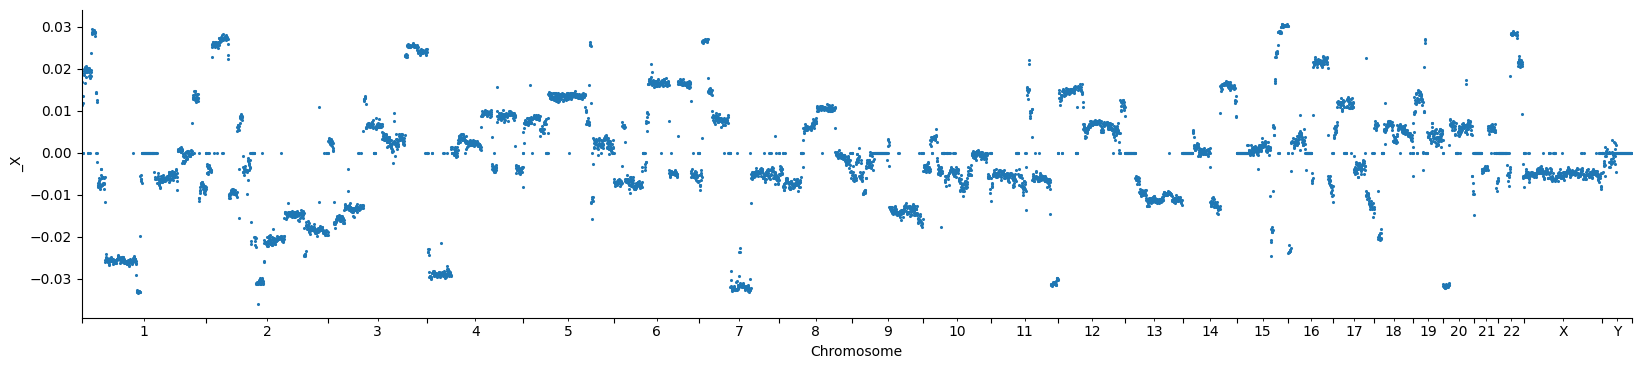

In [16]:

pcadata = scgenome.tl.pca_loadings(hmmcopy, layer='copy')

fig = plt.figure(figsize=(20, 4))
scgenome.pl.plot_cn_profile(
    pcadata, 'PC1',
    value_layer_name=None,
    squashy=False)  # Changed from rawy=True as this is not defined - KG

fig = plt.figure(figsize=(20, 4))
scgenome.pl.plot_cn_profile(
    pcadata, 'PC2',
    value_layer_name=None,
    squashy=False)  # Changed from rawy=True as this is not defined - KG
